# Analyze responses
The following is an example of the analysis that can be done on individual responses that are saved when running `token_benchmark_ray.py` with the flag `--results-dir` which enables the saving of all responses.

In [1]:
import os
import json
import pandas as pd
from typing import List
import plotly.graph_objects as go
import numpy as np

## Read the input json file

In [2]:
# path to the individual responses json file
individual_responses_path = f'../data/demos/mara/vijay_tests/deepseek_r1_0324/deepseek_r1_0324_acb/20251028-155938.135797/realworkload_0_DeepSeek-V3-0324-batch_1000_100_12-0_exponential_stream_5421834a-98e2-484b-906b-e5be1146a3b9_individual_responses.json'
df_user = pd.read_json(individual_responses_path)
df_user = df_user[df_user['error_code'].isnull()]

In [3]:
# for non-batching endpoints, batching_exposed will be False
batching_exposed = True
if df_user["batch_size_used"].isnull().all():
    batching_exposed = False
by_batch_size_suffix = ' by batch size' if batching_exposed else ''

## Server vs client metrics
Following charts show a comparison between server-side and client-side metrics across different performance metrics

In [ ]:

def plot_client_vs_server_barplots(df_user: pd.DataFrame, x_col: str, y_cols: List[str], legend_labels: List[str], title: str, ylabel: str, xlabel: str, batching_exposed: bool = False) -> None:
    """
    Plots bar plots for client vs server metrics from a DataFrame.

    Args:
        df_user (pd.DataFrame): The DataFrame containing the data to plot.
        x_col (str): The column name to be used as the x-axis.
        y_cols (List[str]): A list of column names to be used as the y-axis.
        legend_labels (List[str]): Human-readable labels for each grouping in y_cols.
        title (str): The title of the plot.
        ylabel (str): The label for the y-axis.
        xlabel (str): The label for the x-axis.
        batching_exposed (bool): boolean identifying if batching was exposed.

    Returns:
        fig (go.Figure): The plotly figure container
    """    
    value_vars = y_cols
    title_text = title
    yaxis_title = ylabel
    xaxis_title = xlabel if batching_exposed else ""

    df_melted = df_user.melt(
        id_vars=[x_col], 
        value_vars=value_vars, 
        var_name='Metric', 
        value_name='Value',
    )
    xgroups = [str(x) for x in sorted(pd.unique(df_melted[x_col]))]
    df_melted[x_col] = [str(x) for x in df_melted[x_col]]

    valsl = {}
    valsr = {}
    for i in xgroups:
        maskl = (df_melted["Metric"] == value_vars[0]) & (df_melted[x_col] == i)
        valsl[i] = np.percentile(df_melted["Value"][maskl], [5, 50, 95])
        maskr = (df_melted["Metric"] == value_vars[1]) & (df_melted[x_col] == i)
        valsr[i] = np.percentile(df_melted["Value"][maskr], [5, 50, 95])

    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x = xgroups,
            y = [0 for _ in xgroups],
            base = [valsl[i][1] for i in xgroups],
            customdata=[legend_labels[0] for _ in xgroups],
            marker={"color":"#325c8c","line":{"color":"#325c8c", "width":2}},
            offsetgroup=0,
            legendgroup=legend_labels[0],
            name=legend_labels[0],
            showlegend=False,
            hovertemplate="<extra></extra><b>%{customdata}</b> median: %{base:.2f}",
        )
    )
    fig.add_trace(
        go.Bar(
            x = xgroups,
            y = [valsl[i][2] - valsl[i][0] for i in xgroups],
            base = [valsl[i][0] for i in xgroups],
            customdata = [valsl[i][2] for i in xgroups],
            marker={"color":"#325c8c"},
            opacity=0.5,
            offsetgroup=0,
            legendgroup=legend_labels[0],
            name=legend_labels[0],
            hovertemplate="<extra></extra>5–95 pctile range: %{base:.2f}–%{customdata:.2f}",
        )
    )
    fig.add_trace(
        go.Bar(
            x = xgroups,
            y= [0 for _ in xgroups],
            base = [valsr[i][1] for i in xgroups],
            customdata=[legend_labels[1] for _ in xgroups],
            marker={"color":"#ee7625","line":{"color":"#ee7625", "width":2}},
            offsetgroup=1,
            legendgroup=legend_labels[1],
            name=legend_labels[1],
            showlegend=False,
            hovertemplate="<extra></extra><b>%{customdata}</b> median: %{base:.2f}",
        )
    )
    fig.add_trace(
        go.Bar(
            x = xgroups,
            y = [valsr[i][2] - valsr[i][0] for i in xgroups],
            base = [valsr[i][0] for i in xgroups],
            customdata = [valsr[i][2] for i in xgroups],
            marker={"color":"#ee7625"},
            opacity=0.5,
            offsetgroup=1,
            legendgroup=legend_labels[1],
            name=legend_labels[1],
            hovertemplate="<extra></extra>5–95 pctile range: %{base:.2f}–%{customdata:.2f}",
        )
    )

    fig.update_layout(
        title_text=title_text,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        barmode="group",
        template="plotly_dark",
        hovermode="x unified",
    )
    
    fig.update_xaxes(
        hoverformat="foo",
        showticklabels=batching_exposed
    )
    
    return fig

In [ ]:
x_col = "batch_size_used"
xaxis_title="Batch size"
value_vars = ['server_output_token_per_s_per_request', 'client_output_token_per_s_per_request']
legend_labels = ["Server", "Client"]
yaxis_title = "Tokens per second, per request"
title_text = "Distribution of output throughput" + by_batch_size_suffix
plot_client_vs_server_barplots(df_user, x_col, value_vars, legend_labels, title_text, yaxis_title, xaxis_title, batching_exposed).show()

In [ ]:
x_col = "batch_size_used"
xaxis_title="Batch size"
value_vars = ['server_ttft_s', 'client_ttft_s']
legend_labels = ["Server", "Client"]
yaxis_title = "TTFT (s), per request"
title_text = "Distribution of Time to First Token (TTFT)" + by_batch_size_suffix
plot_client_vs_server_barplots(df_user, x_col, value_vars, legend_labels, title_text, yaxis_title, xaxis_title, batching_exposed).show()

In [ ]:
x_col = "batch_size_used"
xaxis_title="Batch size"
value_vars = ['server_end_to_end_latency_s', 'client_end_to_end_latency_s']
legend_labels = ["Server", "Client"]
yaxis_title = "Latency (s), per request"
title_text = "Distribution of end-to-end latency" + by_batch_size_suffix
plot_client_vs_server_barplots(df_user, x_col, value_vars, legend_labels, title_text, yaxis_title, xaxis_title, batching_exposed).show()

## Summarize results
Group results by batch and get sum of number of tokens, mean throughput, mean TTFT, and batch frequency. Also, calculate the total number of output tokens per batch.

In [ ]:
df_summary_thorughput = df_user.groupby('batch_size_used', dropna=False)['server_output_token_per_s_per_request'].mean().reset_index()
df_summary_output_tokens = df_user.groupby('batch_size_used', dropna=False)['server_number_output_tokens'].sum().reset_index()
df_summary_ttft = df_user.groupby('batch_size_used', dropna=False)['server_ttft_s'].mean().reset_index()
df_summary_count = df_user.groupby('batch_size_used', dropna=False).size().reset_index(name='Counts')


df_summary = pd.merge(df_summary_thorughput, df_summary_output_tokens, on='batch_size_used', how='inner')
df_summary = pd.merge(df_summary, df_summary_ttft, on='batch_size_used', how='inner')
df_summary = pd.merge(df_summary, df_summary_count, on='batch_size_used', how='inner')
if batching_exposed:
    df_summary['server_total_output_tokens_per_s'] = df_summary['server_output_token_per_s_per_request'] * df_summary['batch_size_used']
    subset_style = [True,False,True,False,True]
else:
    subset_style = [True,False,True,False]

df_summary.rename(columns={
    "batch_size_used": "Batch size",
    "server_output_token_per_s_per_request": "Avg. server output tokens per sec per request",
    "server_number_output_tokens": "Total output tokens",
    "server_ttft_s": "Avg. server TTFT (s)",
    "Counts": "Total number of completed requests",
    "server_total_output_tokens_per_s": "Avg. server total output tokens per second"
}, 
inplace=True)

df_summary.set_index("Batch size", inplace=True)
df_summary = df_summary.reset_index().fillna("").set_index('Batch size')
df_summary.T.style \
    .format("{:.4f}", subset=(subset_style,[True]*len(df_summary))) \
    .format("{:.4f}", subset=(subset_style,[True]*len(df_summary)))

Show stats from the corresponding summary file.

In [ ]:
# Read summary json file 

json_filename = individual_responses_path.split('/')[-1]
summary_filename = json_filename.replace('individual_responses.json', 'summary.json')
summary_path = os.path.join('/'.join(individual_responses_path.split('/')[:-1]), summary_filename)

with open(summary_path, 'r') as f:
    json_data = json.load(f)
df_summary = pd.DataFrame(json_data, index=[0])
df_summary = df_summary.rename(columns=lambda x: x.replace('results_', '')
                   .replace('_quantiles', '')
                   .replace('_per_request', '')).copy()

# Show summary

with pd.option_context('display.max_rows', None):
    display(df_summary.T)

## Time taken
- Approximate computation to compare the time spent waiting due to TTFT vs response generation time
- Compute the time that calls are cumulatively waiting for time-to-first-token vs time to generate tokens

In [4]:

import numpy as np

if batching_exposed:
    # calculate number of batches executed in each batch size
    df_summary['num_batches_executed'] = np.ceil(df_summary['Total number of completed requests'] / df_summary.index.get_level_values('Batch size'))

    # calculate average time taken per request in each batch size
    df_summary['output_tokens_per_request'] = df_summary['Total output tokens']/df_summary['Total number of completed requests']
    df_summary['time_taken_per_request'] = df_summary['output_tokens_per_request']/df_summary['Avg. server output tokens per sec per request']

    # calculate total ttft and generation times across all batch sizes
    total_wait_time_ttft = (df_summary['num_batches_executed']*df_summary['Avg. server TTFT (s)']).sum()
    total_generation_time = (df_summary['num_batches_executed']*df_summary['time_taken_per_request']).sum()

    print(f'Total wait time due to ttft (mins) = {total_wait_time_ttft/60:,.4f}')
    print(f'Total time (mins) = {(total_wait_time_ttft + total_generation_time)/60:,.4f}')
else:
    # since batch size is not exposed, we calculate the total time taken for all requests
    total_wait_time_ttft = df_user['server_ttft_s'].sum()
    total_generation_time = df_user['server_end_to_end_latency_s'].sum() - df_user['server_ttft_s'].sum()
    total_time = df_user['server_end_to_end_latency_s'].sum()
    
    print(f'Total wait time due to ttft (mins) = {total_wait_time_ttft/60:,.4f}')
    print(f'Total time (mins) = {(total_time)/60:,.4f}')

Total wait time due to ttft (mins) = 289.0072
Total time (mins) = 2,261.8984


## Requests Gantt Chart
- Blue bar is the total time to get back full response
- Orange line is the time call is waiting to be executed

In [45]:
def plot_requests_gantt_chart(df_user: pd.DataFrame):
    """
    Plots a Gantt chart of response timings across all requests

    # if i> 100:
    #     break
    Args:
        df_user (pd.DataFrame): The DataFrame containing the data to plot.

    Returns:
        fig (go.Figure): The plotly figure container
    """    
    requests = df_user.index+1
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            y=requests,
            x=1000*df_user["client_ttft_s"],
            base=[str(x) for x in df_user["start_time"]],
            name="Client TTFT",
            orientation="h",
            marker_color="#ee7625",
        )
    )
    fig.add_trace(
        go.Bar(
            y=requests,
            x=1000*df_user["server_ttft_s"],
            base=[str(x) for x in df_user["start_time"]],
            name="Servet TTFT",
            orientation="h",
            marker_color="#325c8c",
        )
    )
    for i in range(0, len(df_user.index), 2):
        fig.add_hrect(y0=i+0.5, y1=i+1.5, line_width=0, fillcolor="grey", opacity=0.1)
    fig.update_xaxes(
        type="date",
        tickformat="%H:%M:%S",
        hoverformat="%H:%M:%S.%2f",)
    fig.update_layout(
        title_text="LLM requests across time",
        xaxis_title="Time stamp",
        yaxis_title="Request index",
        template="plotly_dark",
    )
    return fig

In [50]:
df_user.tail(5)[['start_time', 'end_time','client_ttft_s', 'server_ttft_s']]

,start_time,end_time,client_ttft_s,server_ttft_s
10154,2025-10-28 17:07:04.870936,2025-10-28 17:07:24.170812,12.111104,1.355372
10155,2025-10-28 17:07:04.968223,2025-10-28 17:07:24.304692,12.021811,1.362922
10156,2025-10-28 17:07:05.011908,2025-10-28 17:07:24.443471,11.979276,0.728540
10157,2025-10-28 17:07:05.123560,2025-10-28 17:07:24.640669,11.879273,0.735271
10158,2025-10-28 17:07:05.288369,2025-10-28 17:07:24.903855,11.727040,0.741614


In [47]:
fig = plot_requests_gantt_chart(df_user.head(100))
fig.show()

In [48]:
fig.write_html("my_interactive_plot-3.html") 

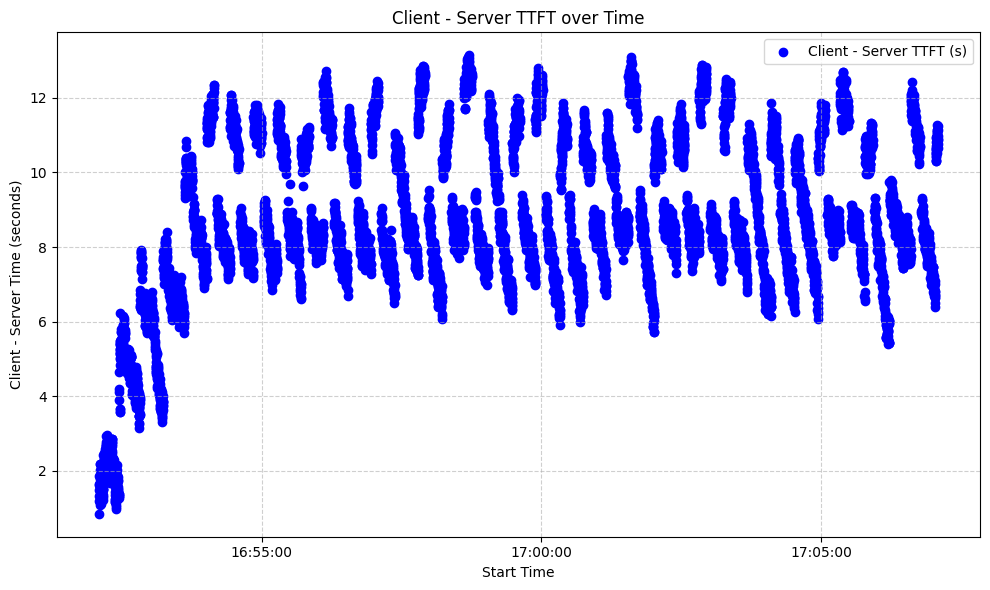

In [6]:
def plot_client_vs_server_scatter(df: pd.DataFrame) -> None:
    """
    Plots scatter plot for client vs server TTFT from a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data to plot.
    """
    from matplotlib import pyplot as plt
    # Convert start_time to datetime
    df["start_time"] = pd.to_datetime(df["start_time"])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df["start_time"], df["client_ttft_s"]-df["server_ttft_s"], color='blue', label='Client - Server TTFT (s)')

    # Labels and legend
    plt.title("Client - Server TTFT over Time")
    plt.xlabel("Start Time")
    plt.ylabel("Client - Server Time (seconds)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M:%S"))

    plt.show()
    
plot_client_vs_server_scatter(df_user)